# Heart Failure Prediction Dataset

This notebook serves as the entry point for our heart disease prediction pipeline.

It reads the input dataset, performs cleaning and transformation, trains a model, and evaluates its performance.

---

##  Table of Contents

1. [Imports and raw data](#imports)  
2. [EDA – Visual Exploration](#eda-visual)  
3. [Preprocessing](#preprocessing)  
4. [Feature Transformation](#features)  
5. [Model Training & Evaluation](#model)
6. [Predicting on New Input Data](#7-predicting-on-new-input-data)

---

Attribute Information

- *Age*: age of the patient [years]
- *Sex*: sex of the patient [M: Male, F: Female]
- *ChestPainType*: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- *RestingBP*: resting blood pressure [mm Hg]
- *Cholesterol*: serum cholesterol [mm/dl]
- *FastingBS*: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- *RestingECG*: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- *MaxHR*: maximum heart rate achieved [Numeric value between 60 and 202]
- *ExerciseAngina*: exercise-induced angina [Y: Yes, N: No]
- *Oldpeak*: oldpeak = ST [Numeric value measured in depression]
- *ST_Slope*: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- *HeartDisease*: output class [1: heart disease, 0: Normal]

##  1. Imports and raw data

All core libraries (Pandas, NumPy, Seaborn...) and our own modular code from `src/`.

In [97]:
import sys
import pandas as pd 
import importlib
import eda
import preprocessing
import models

sys.path.insert(0, './src/')
importlib.reload(eda)
importlib.reload(preprocessing)
importlib.reload(models)

from models import split_data, select_best_model, tune_catboost_hyperparameters, evaluate_model

# Load raw data
df = pd.read_csv('data/heart.csv')


##  2. Exploratory Data Analysis

In [11]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.expand_frame_repr', False)  

# Print head of the dataset
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [12]:
# Show basic information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [13]:
# Check how many nulls are present in dataframe
eda.check_nulls(df)


 Amount of nulls per column
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

 Amount of rows that have at least a NaN value: 0
Empty DataFrame
Columns: [Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease]
Index: []


### Visual Exploration

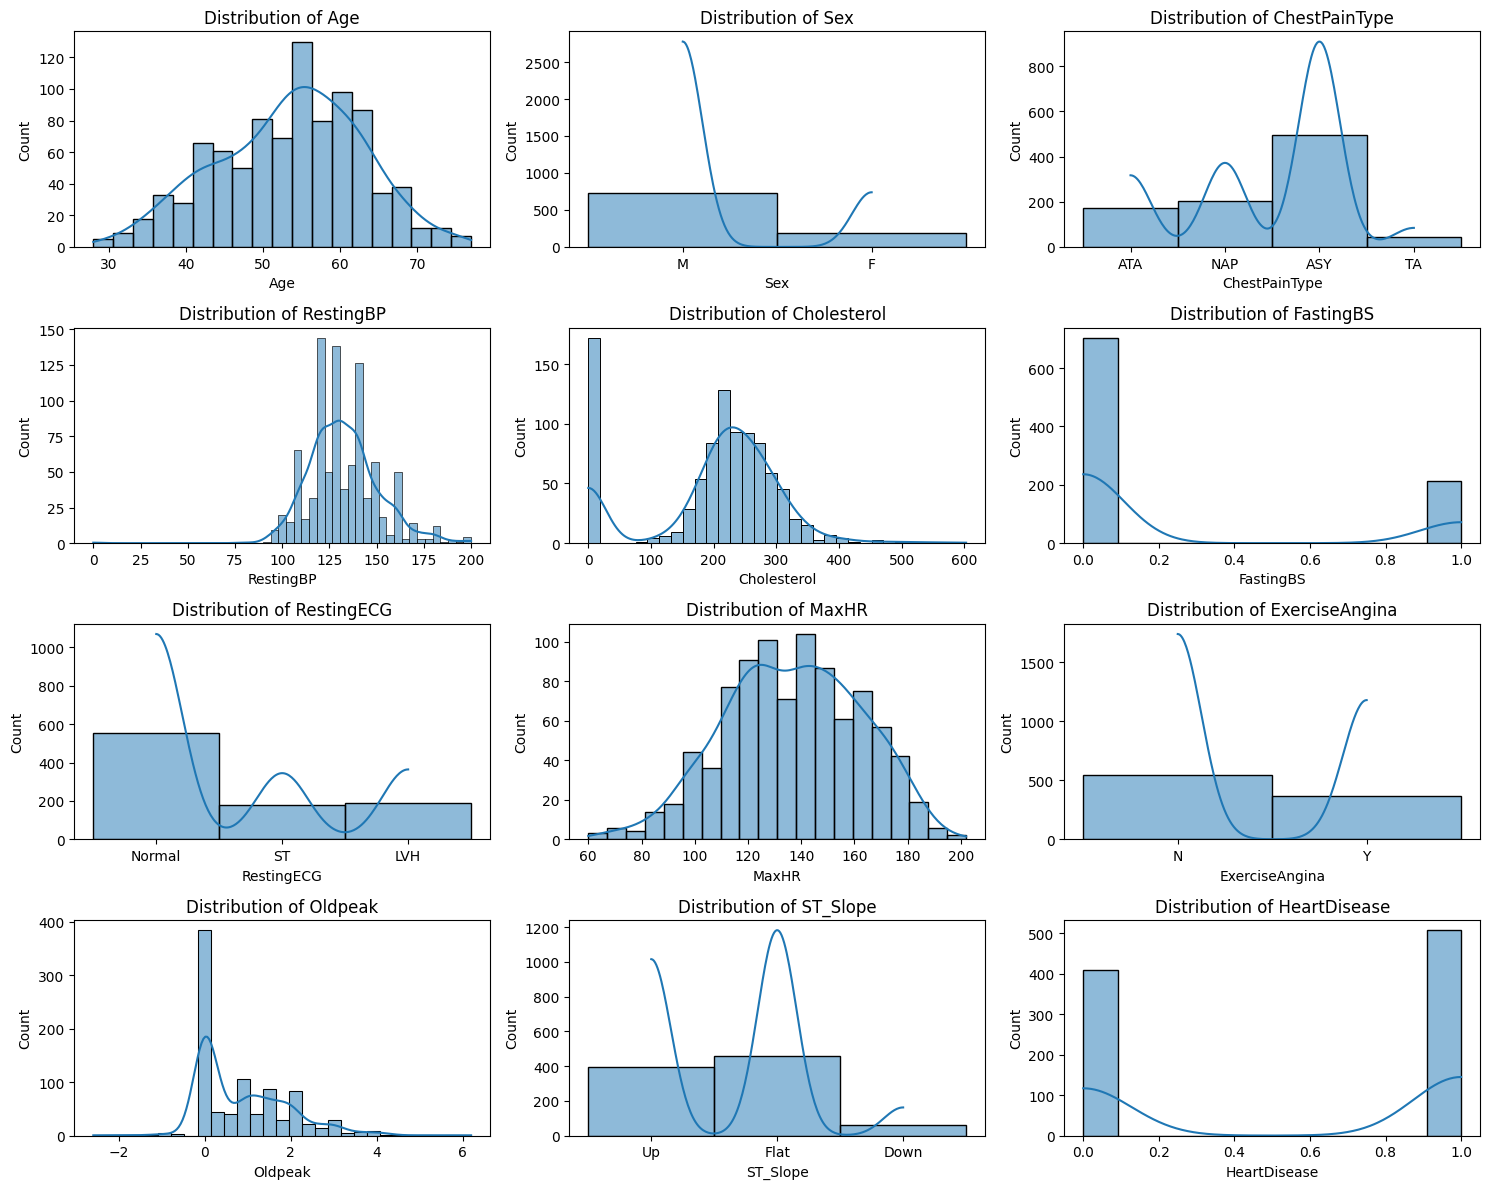

In [14]:
eda.plot_distributions(df)

In [32]:
# Print statistics of numeric features
cat_features, num_features = eda.string_num_cols(df, "HeartDisease")
eda.describe_num_cols(df, num_features, "HeartDisease")




Statistical data of the numerical columns:
             count     mean      std   min     25%    50%    75%    max
Age          918.0   53.511    9.433  28.0   47.00   54.0   60.0   77.0
RestingBP    918.0  132.397   18.514   0.0  120.00  130.0  140.0  200.0
Cholesterol  918.0  198.800  109.384   0.0  173.25  223.0  267.0  603.0
FastingBS    918.0    0.233    0.423   0.0    0.00    0.0    0.0    1.0
MaxHR        918.0  136.809   25.460  60.0  120.00  138.0  156.0  202.0
Oldpeak      918.0    0.887    1.067  -2.6    0.00    0.6    1.5    6.2

Correlation Matrix:


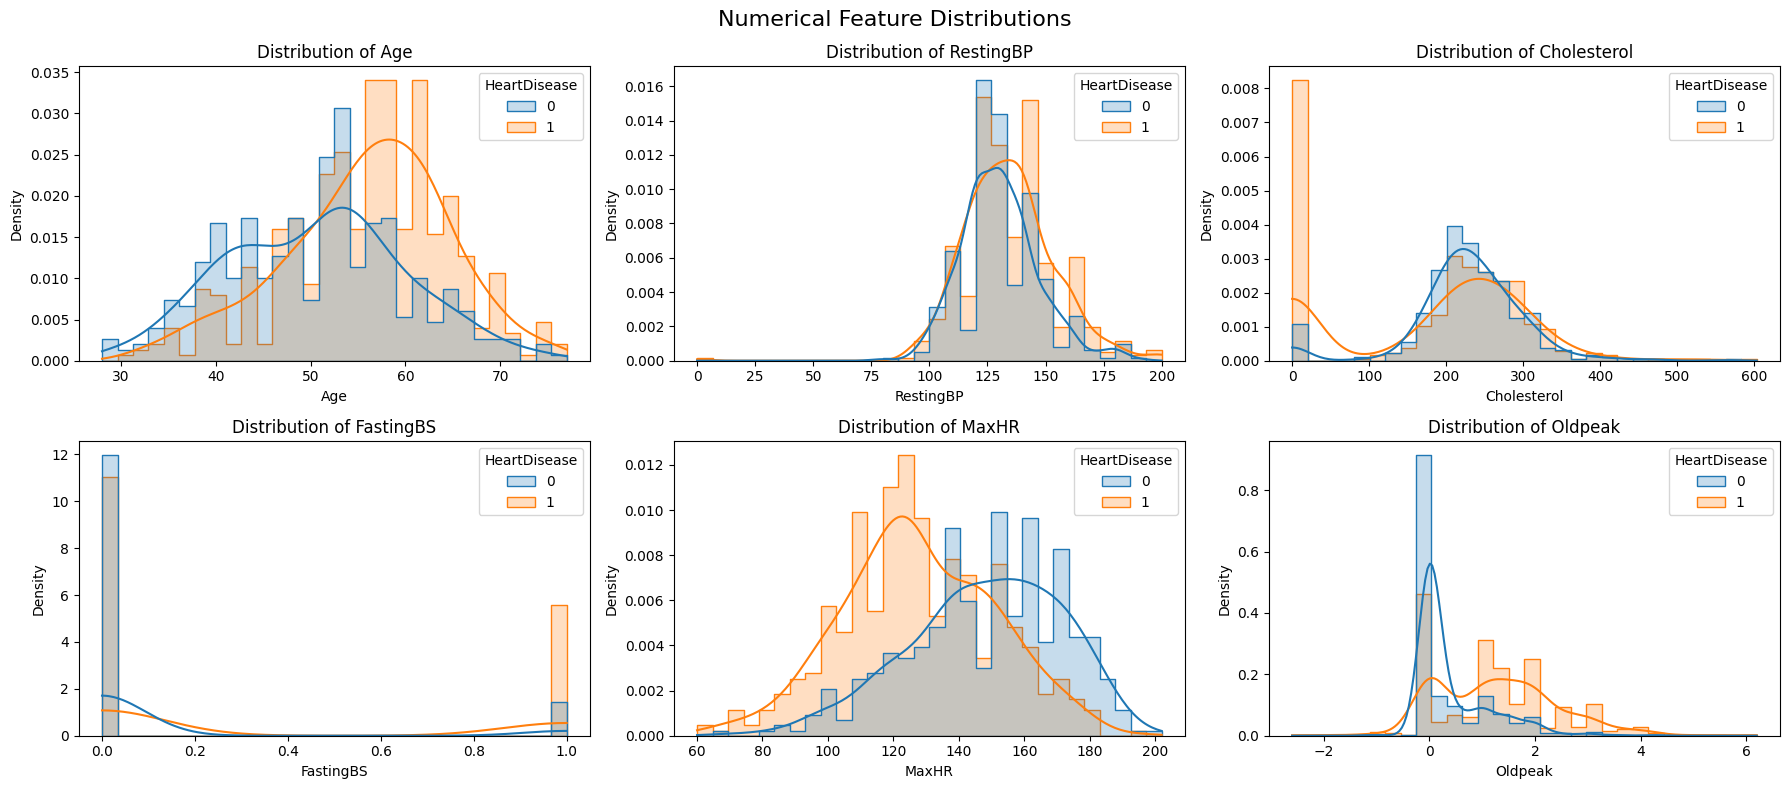

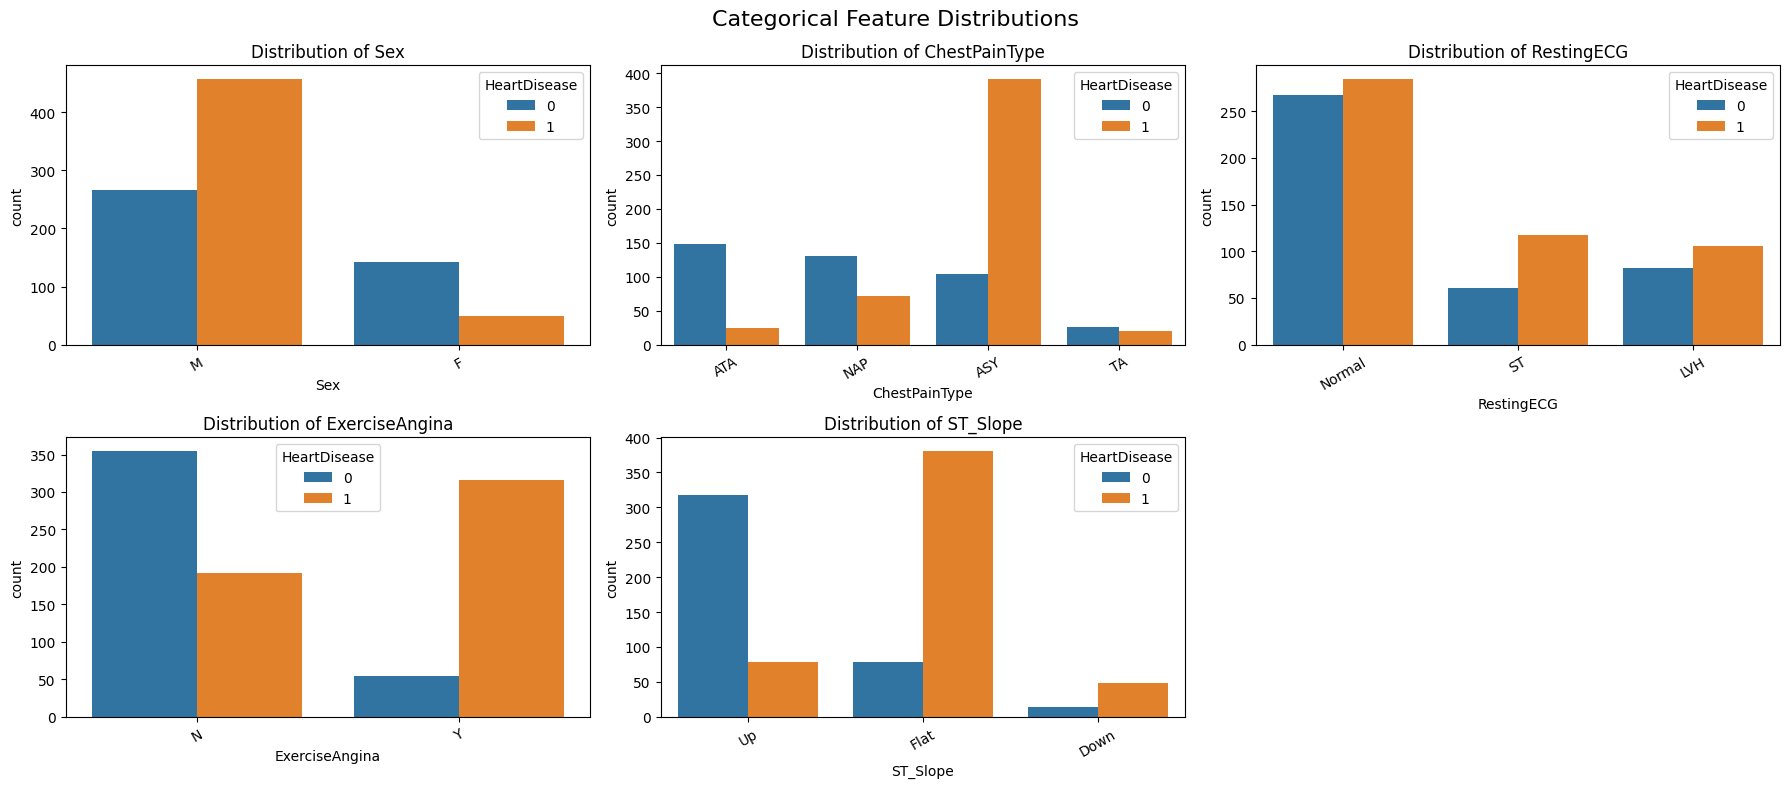

In [33]:
# Plots the distribution of all numerical and optional categorical features 
eda.plot_feature_distributions(df,include_categorical=True)

### EDA: Conclusions

### Overall Distribution
The sample contains 918 individuals.

The target variable HeartDisease is binary:

Mean: 0.553: Approximately 55% have heart disease, and 45% do not.

The average age is 53.5 years, ranging from 28 to 77 years.
This aligns with expectations for cardiac risk: middle-aged and older individuals.

### Key Clinical Variables
Resting Blood Pressure (RestingBP)
Average: 132 mmHg, standard deviation: ±18.5

Minimum: 0 : Likely an error or missing value (requires cleaning).

Values up to 200 mmHg, indicating possible severe hypertension in some cases.

Cholesterol
Mean: ~199 mg/dL, with values reaching up to 603 mg/dL, which are extremely high.

Minimum of 0 : Again, likely incorrectly coded missing values.

Fasting Blood Sugar (FastingBS)
Binary variable: majority are 0 (normal), only about 23% have high values (likely >120 mg/dL).

Maximum Heart Rate (MaxHR)
Mean: ~137 bpm, with a maximum of 202 bpm.

Shows high variability → may be useful in combination with ExerciseAngina.

ST Depression (Oldpeak)
Mean: 0.89, ranging from -2.6 to 6.2.

Negative values require validation, as typically Oldpeak ≥ 0 is expected in clinical contexts.

### Medically Relevant Categorical Variables
Chest Pain Type (ChestPainType)
Types like ASY (asymptomatic), NAP, ATA are present.

ASY is generally more associated with heart disease.

Exercise-Induced Angina (ExerciseAngina)
Indicates the appearance of angina during exercise → a known risk factor.

ST Segment Slope (ST_Slope)
Categories include Flat, Up, etc.

Flat or Down slopes may be associated with a higher probability of heart disease.

### Potential Data Quality Issues
Anomalous values:
RestingBP and Cholesterol contain zeros, which are not clinically viable.

These are likely missing values incorrectly encoded as zeros, and require handling (either imputation or removal).

Negative Oldpeak values also require validation, as they are not standard in clinical interpretation.

##  3. Preprocessing
Separate the features from the target variable, fit transformations on the training features, and apply them to the data.

In [34]:
random_state = 42

y = df["HeartDisease"]
X = df.drop("HeartDisease", axis=1)  

In [35]:
# Number and percentage of anomalous values
preprocessing.count_anomalous(df)




 Number of null values ​​in the Cholesterol feature: 172, (18.74%)

 Number of negative values ​​in the Oldpeak characteristic: 13, (1.42%)

 Number of null values ​​in the RestingBP feature: 1, (0.11%)


In [47]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=random_state)

In [48]:
# Imputation
invalids = {
    'Oldpeak': lambda x: pd.isna(x) | (x < 0),
    'RestingBP': lambda x: pd.isna(x) | (x == 0),
    'Cholesterol': lambda x: pd.isna(x) | (x == 0)
}

imputer = preprocessing.MedianImputer(
    impute_cols=['Oldpeak', 'RestingBP', 'Cholesterol'],
    invalid_conditions=invalids
)

imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [49]:
# Encoding for categorical features and scaling for numerical features
preprocessor = preprocessing.preprocessor(cat_features=cat_features,
                                num_features=num_features,
                                fit=True,
                                X=X_train,
                                y=y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)


# 4. Model Training & Evaluation

In [96]:

# Models to train
models = ["logistic_regressor","random_forest", "xgboost", "Catboost"]

# Best Model
best_model = select_best_model(X_train, y_train, models)

Evaluating models with cross-validation...
--------------------------------------------------
logistic_regressor | CV Score f1: 0.8693 (+/- 0.0249)
random_forest   | CV Score f1: 0.8774 (+/- 0.0458)
xgboost         | CV Score f1: 0.8656 (+/- 0.0428)
Catboost        | CV Score f1: 0.8782 (+/- 0.0367)
--------------------------------------------------
Best Model: Catboost with CV Score (f1): 0.8782


In [98]:
# Tunning Hyperparameters
model_tun, results = tune_catboost_hyperparameters(X_train, y_train)

Starting hyperparameter tuning for CatBoost...
Search space: 8 parameters
------------------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning completed in 82.71 seconds
------------------------------------------------------------
BEST PARAMETERS:
  subsample           : 1.0
  random_strength     : 0
  learning_rate       : 0.01
  l2_leaf_reg         : 1
  iterations          : 200
  depth               : 5
  border_count        : 255
  bagging_temperature : 1.0

Best CV Score (F1): 0.8860


MODEL EVALUATION RESULTS
Accuracy:     0.9183
Precision:    0.9069
Recall:       0.9476
F1-Score:     0.9268
Specificity:  0.8829
NPV:          0.9333
ROC AUC:      0.9755

Confusion Matrix:
                 Predicted
              No    Yes
Actual   No   294    39
         Yes   21   380

Detailed Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.93      0.88      0.91       333
   Heart Disease       0.91      0.95      0.93       401

        accuracy                           0.92       734
       macro avg       0.92      0.92      0.92       734
    weighted avg       0.92      0.92      0.92       734



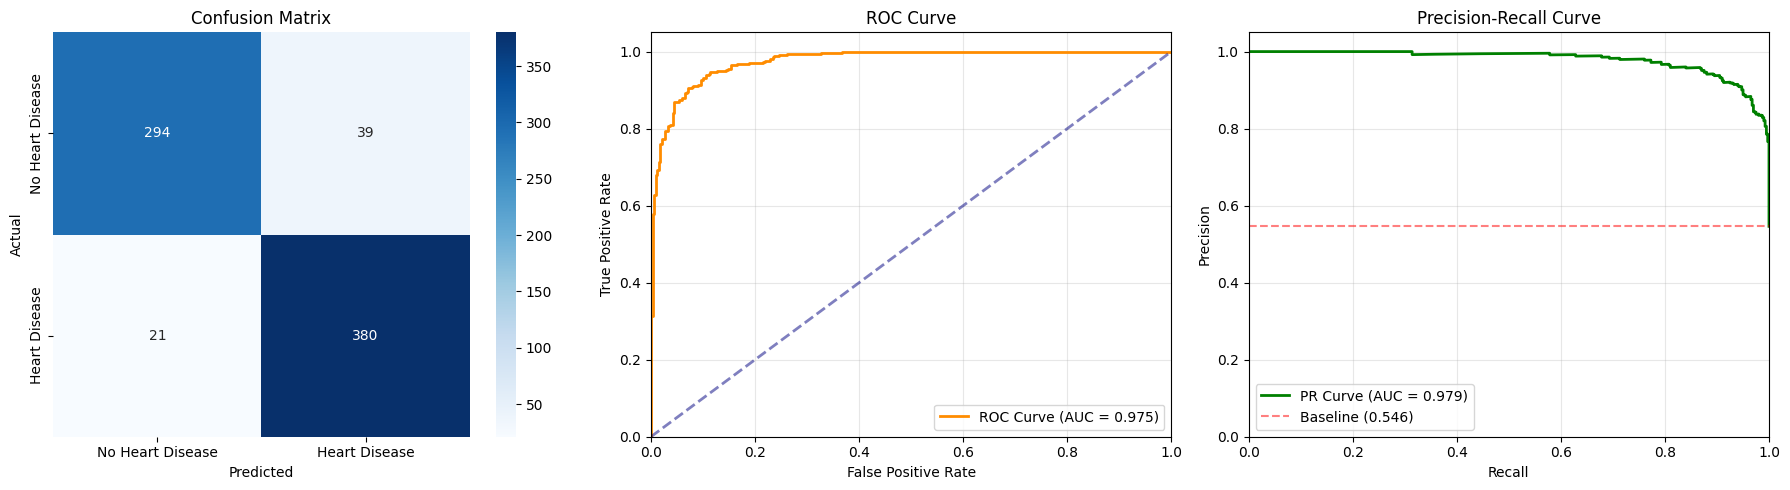

In [101]:
train_results = evaluate_model(model_tun, X_train, y_train)

MODEL EVALUATION RESULTS
Accuracy:     0.8641
Precision:    0.9020
Recall:       0.8598
F1-Score:     0.8804
Specificity:  0.8701
NPV:          0.8171
ROC AUC:      0.9322

Confusion Matrix:
                 Predicted
              No    Yes
Actual   No    67    10
         Yes   15    92

Detailed Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.82      0.87      0.84        77
   Heart Disease       0.90      0.86      0.88       107

        accuracy                           0.86       184
       macro avg       0.86      0.86      0.86       184
    weighted avg       0.87      0.86      0.86       184



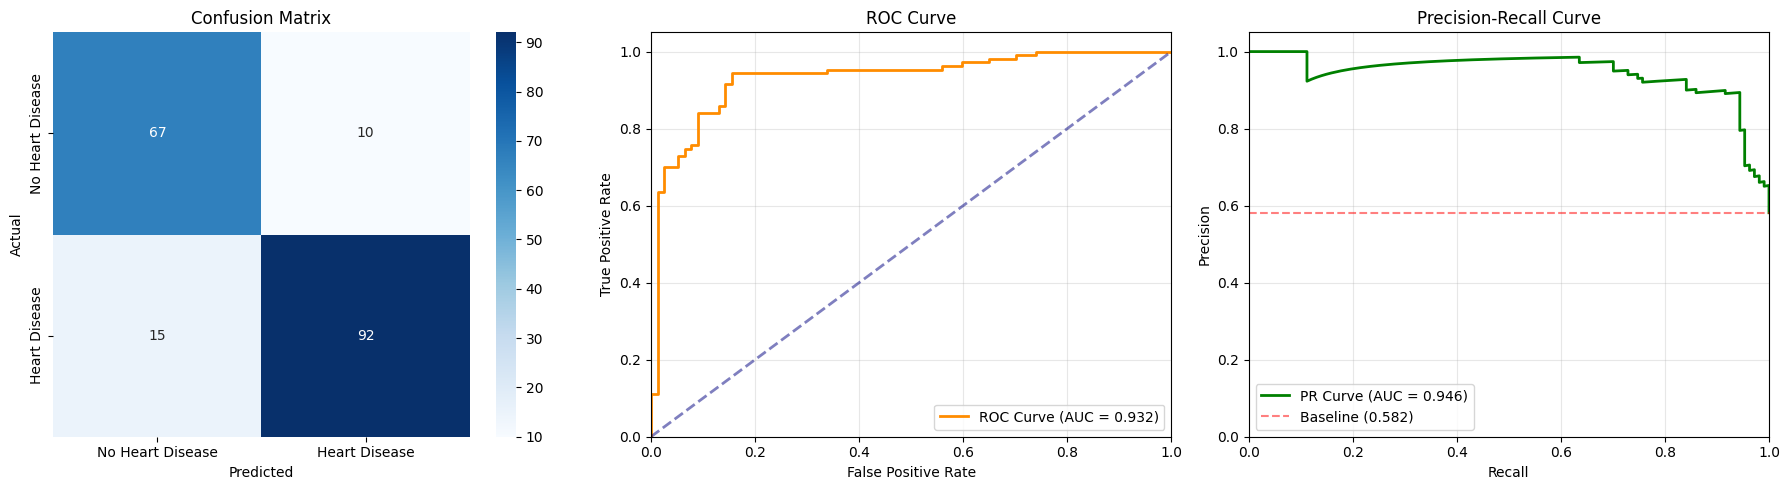

In [55]:
# Evaluate the Model
test_results=evaluate_model(model_tun, X_test, y_test)